# Load Data

In [2]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
!pip install scikeras
from scikeras.wrappers import KerasClassifier

In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
# Use the file upload widget
from google.colab import files
files.upload()  # Upload your kaggle.json file here

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!cp kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [ ]:
!unzip home-credit-credit-risk-model-stability.zip

In [4]:
dataPath = "/content/"

In [5]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [6]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# Join Tables & Feature Engineering

In [7]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [9]:
data = data.to_pandas()
data['date_decision'] = pd.to_datetime(data['date_decision'])
print(f"Date range: {data['date_decision'].min()} to {data['date_decision'].max()}")
print(f"Week range: {data['WEEK_NUM'].min()} to {data['WEEK_NUM'].max()}")

Date range: 2019-01-01 00:00:00 to 2020-10-05 00:00:00
Week range: 0 to 91


In [10]:
# Pre-COVID training, COVID validation/testing
covid_start = pd.Timestamp('2020-03-01')
mid_covid = pd.Timestamp('2020-07-01')

# Split data based on these dates
train_data = data[data['date_decision'] < covid_start]             # Pre-COVID (Jan 2019-Feb 2020)
valid_data = data[(data['date_decision'] >= covid_start) &
                  (data['date_decision'] < mid_covid)]            # Early COVID (Mar 2020-Jun 2020)
test_data = data[data['date_decision'] >= mid_covid]              # Later COVID (Jul 2020-Oct 2020)

# Print split information
print(f"Training (pre-COVID): {len(train_data)} samples ({train_data['date_decision'].min()} to {train_data['date_decision'].max()})")
print(f"Validation (early COVID): {len(valid_data)} samples ({valid_data['date_decision'].min()} to {valid_data['date_decision'].max()})")
print(f"Test (later COVID): {len(test_data)} samples ({test_data['date_decision'].min()} to {test_data['date_decision'].max()})")

Training (pre-COVID): 1232695 samples (2019-01-01 00:00:00 to 2020-02-29 00:00:00)
Validation (early COVID): 143724 samples (2020-03-01 00:00:00 to 2020-06-30 00:00:00)
Test (later COVID): 150240 samples (2020-07-01 00:00:00 to 2020-10-05 00:00:00)


In [11]:
cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)
print(cols_pred)

base_train = train_data[["case_id", "WEEK_NUM","MONTH", "target"]]
y_train = train_data["target"]
X_train = train_data[cols_pred]

base_valid = valid_data[["case_id", "WEEK_NUM","MONTH", "target"]]
y_valid = valid_data["target"]
X_valid = valid_data[cols_pred]

base_test = test_data[["case_id", "WEEK_NUM","MONTH", "target"]]
y_test = test_data["target"]
X_test = test_data[cols_pred]

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

<ipython-input-3-601ef9b9fd56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("string").astype('category')
<ipython-input-3-601ef9b9fd56>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
<ipython-input-3-601ef9b9fd56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [12]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (1232695, 48)
Valid: (143724, 48)
Test: (150240, 48)


In [13]:
print(f"Train: {y_train.shape}")
print(f"Valid: {y_valid.shape}")
print(f"Test: {y_test.shape}")

Train: (1232695,)
Valid: (143724,)
Test: (150240,)


# Reduce Memory Usage

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [15]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
X_test = reduce_mem_usage(X_test)

<ipython-input-14-b5f18661dcfe>:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-14-b5f18661dcfe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)
<ipython-input-14-b5f18661dcfe>:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-14-b5f18661dcfe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

# Exploratory Analysis & Preprocessing

In [16]:
base_train["target"].sum()/base_train["target"].count()

np.float64(0.03253440632110944)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1232695 entries, 0 to 1495629
Data columns (total 48 columns):
 #   Column                           Non-Null Count    Dtype   
---  ------                           --------------    -----   
 0   amtinstpaidbefduel24m_4187115A   738244 non-null   float32 
 1   annuity_780A                     1232695 non-null  float32 
 2   annuitynextmonth_57A             1232693 non-null  float32 
 3   avginstallast24m_3658937A        707648 non-null   float32 
 4   avglnamtstart24m_4525187A        116566 non-null   float32 
 5   avgoutstandbalancel6m_4187114A   522515 non-null   float32 
 6   avgpmtlast12m_4525200A           322285 non-null   float32 
 7   credamount_770A                  1232695 non-null  float32 
 8   currdebt_22A                     1232693 non-null  float32 
 9   currdebtcredtyperange_828A       1232693 non-null  float32 
 10  disbursedcredamount_1113A        1232695 non-null  float32 
 11  downpmt_116A                     1232695 n

In [18]:
X_train.isna().sum() / X_train.shape[0]

,0
amtinstpaidbefduel24m_4187115A,0.401114
annuity_780A,0.000000
annuitynextmonth_57A,0.000002
avginstallast24m_3658937A,0.425934
avglnamtstart24m_4525187A,0.905438
avgoutstandbalancel6m_4187114A,0.576120
avgpmtlast12m_4525200A,0.738553
credamount_770A,0.000000
currdebt_22A,0.000002
currdebtcredtyperange_828A,0.000002


In [19]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64', 'float16', 'float32']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [21]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.wa

# Artificial Neural Network

In [22]:
import gc
del data
gc.collect()

172

In [23]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['AUC'])

In [25]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping],
    verbose=2)

Epoch 1/50
9631/9631 - 68s - 7ms/step - AUC: 0.6366 - loss: 0.1471 - val_AUC: 0.7191 - val_loss: 0.1348
Epoch 2/50
9631/9631 - 82s - 9ms/step - AUC: 0.6836 - loss: 0.1372 - val_AUC: 0.7281 - val_loss: 0.1328
Epoch 3/50
9631/9631 - 78s - 8ms/step - AUC: 0.6930 - loss: 0.1360 - val_AUC: 0.7332 - val_loss: 0.1324
Epoch 4/50
9631/9631 - 82s - 9ms/step - AUC: 0.6996 - loss: 0.1353 - val_AUC: 0.7373 - val_loss: 0.1320
Epoch 5/50
9631/9631 - 61s - 6ms/step - AUC: 0.7052 - loss: 0.1347 - val_AUC: 0.7393 - val_loss: 0.1322
Epoch 6/50
9631/9631 - 65s - 7ms/step - AUC: 0.7092 - loss: 0.1342 - val_AUC: 0.7415 - val_loss: 0.1322
Epoch 7/50
9631/9631 - 81s - 8ms/step - AUC: 0.7128 - loss: 0.1338 - val_AUC: 0.7418 - val_loss: 0.1313
Epoch 8/50
9631/9631 - 62s - 6ms/step - AUC: 0.7161 - loss: 0.1334 - val_AUC: 0.7452 - val_loss: 0.1306
Epoch 9/50
9631/9631 - 64s - 7ms/step - AUC: 0.7184 - loss: 0.1331 - val_AUC: 0.7452 - val_loss: 0.1313
Epoch 10/50
9631/9631 - 65s - 7ms/step - AUC: 0.7204 - loss: 0.1

In [26]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = model.predict(X)
    train_prevalence = y_train.mean()
    threshold = np.percentile(y_pred, 100 * (1 - train_prevalence))
    y_pred_labels = (y_pred > threshold).astype(int)
    base["score"] = y_pred
    base["pred"] = y_pred_labels

38522/38522 ━━━━━━━━━━━━━━━━━━━━ 171s 4ms/step


<ipython-input-26-3f685e86d8ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
<ipython-input-26-3f685e86d8ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["pred"] = y_pred_labels


4492/4492 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


<ipython-input-26-3f685e86d8ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
<ipython-input-26-3f685e86d8ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["pred"] = y_pred_labels


4695/4695 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


<ipython-input-26-3f685e86d8ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
<ipython-input-26-3f685e86d8ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["pred"] = y_pred_labels


# Evaluation

In [27]:
print(f'The AUC score on the train set for ANN is: {roc_auc_score(base_train["target"], base_train["score"])}')
print(f'The AUC score on the valid set for ANN is: {roc_auc_score(base_valid["target"], base_valid["score"])}')
print(f'The AUC score on the test set for ANN is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set for ANN is: 0.7444308543334298
The AUC score on the valid set for ANN is: 0.7481452133010275
The AUC score on the test set for ANN is: 0.7547214630843773


In [28]:
print(f'The classification error on the train set for ANN is: {1- accuracy_score(base_train["target"], base_train["pred"])}')
print(f'The classification error on the valid set for ANN is: {1-accuracy_score(base_valid["target"], base_valid["pred"])}')
print(f'The classification error on the test set for ANN is: {1-accuracy_score(base_test["target"], base_test["pred"])}')

The classification error on the train set for ANN is: 0.05462665136144784
The classification error on the valid set for ANN is: 0.05417327655784698
The classification error on the test set for ANN is: 0.045946485623003186


In [29]:
print(f'The brier score on the train set for ANN is: {brier_score_loss(base_train["target"], base_train["score"])}')
print(f'The brier score on the valid set for ANN is: {brier_score_loss(base_valid["target"], base_valid["score"])}')
print(f'The brier score on the test set for ANN is: {brier_score_loss(base_test["target"], base_test["score"])}')

The brier score on the train set for ANN is: 0.030369922527030815
The brier score on the valid set for ANN is: 0.030433072018366192
The brier score on the test set for ANN is: 0.020139483536333956


In [30]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return gini_in_time, avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [31]:
gini_in_time_train, stability_score_train = gini_stability(base_train)
gini_in_time_valid, stability_score_valid = gini_stability(base_valid)
gini_in_time_test, stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the valid set is: {stability_score_valid}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.4628925521693283
The stability score on the valid set is: 0.4485783362593159
The stability score on the test set is: 0.3483414015121803


In [32]:
# Combine all three datasets into one
all_scores_combined = pd.concat(
    [base_train, base_valid, base_test],
    axis=0,          # Concatenate vertically (stack rows)
    ignore_index=False  # Keep original indices
)

In [33]:
gini_in_time, stability_score = gini_stability(all_scores_combined)

print(f'The stability score is: {stability_score}')

The stability score is: 0.46328692800639903


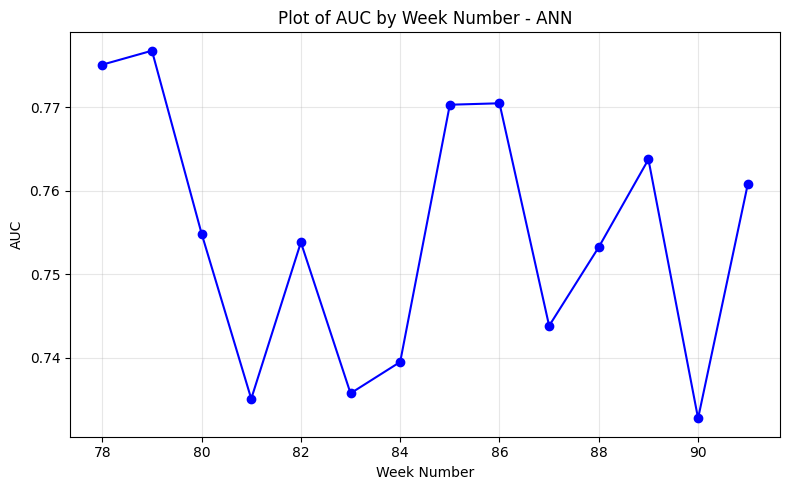

In [34]:
import matplotlib.pyplot as plt
import numpy as np


# Convert Gini to AUC: AUC = (Gini + 1) / 2
# Using list comprehension to apply the operation to each element
auc_values = [(g + 1) / 2 for g in gini_in_time_test]

# Create x-axis values (indices)
x = base_test["WEEK_NUM"].unique()

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, auc_values, 'o-', color='blue')

# Add labels and title
plt.xlabel('Week Number')
plt.ylabel('AUC')
plt.title('Plot of AUC by Week Number - ANN')

# Add grid
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

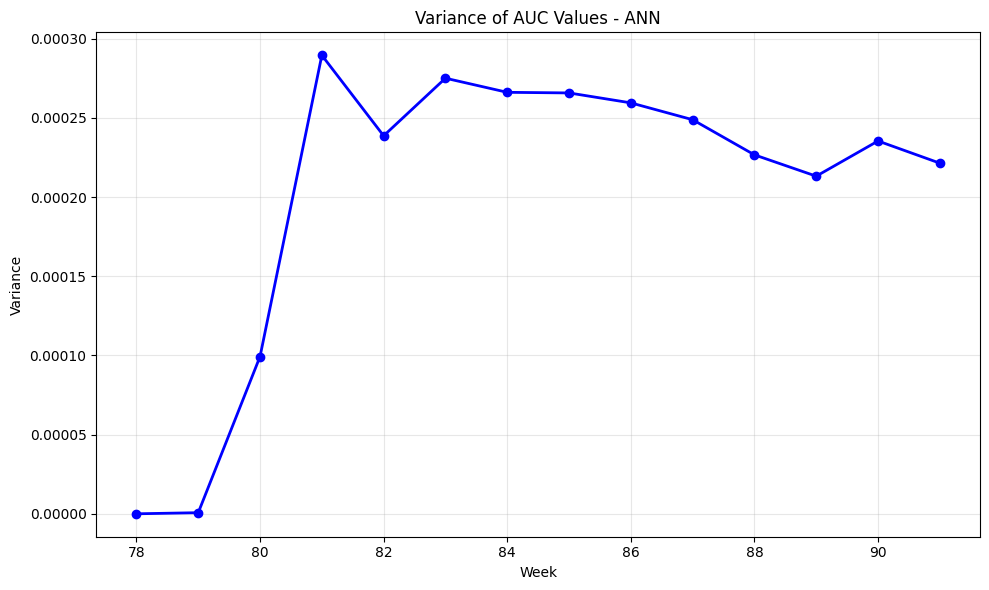

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate rolling variance (variance at each point using all previous points)
rolling_variance = []
for i in range(1, len(auc_values) + 1):
    subset = auc_values[:i]
    variance = np.var(subset)
    rolling_variance.append(variance)

# Plot the variance
plt.figure(figsize=(10, 6))
plt.plot(base_test["WEEK_NUM"].unique() , rolling_variance, 'o-', color='blue', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Variance')
plt.title('Variance of AUC Values - ANN')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
def calculate_weekly_rolling_stability(df, window_weeks, w_fallingrate=88.0, w_resstd=-0.5):
    """
    Calculate rolling stability metrics on a weekly basis.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing WEEK_NUM, target, and score columns
    window_weeks : int, default=4
        Number of weeks to include in each rolling window
    w_fallingrate : float, default=88.0
        Weight for the falling rate
    w_resstd : float, default=-0.5
        Weight for the residual standard deviation

    Returns:
    --------
    pd.DataFrame
        DataFrame with weekly stability metrics
    """
    # Get unique weeks
    unique_weeks = sorted(df['WEEK_NUM'].unique())

    # For each week starting from window_weeks, calculate stability using previous window_weeks
    results = []

    for i in range(window_weeks-1, len(unique_weeks)):
        # Get the current ending week
        end_week = unique_weeks[i]

        # Get the weeks in this window
        window_week_nums = unique_weeks[i-(window_weeks-1):i+1]

        # Filter data for these weeks
        window_data = df[df['WEEK_NUM'].isin(window_week_nums)].copy()

        # Calculate stability for this window
        gini_values, stability_score = gini_stability(window_data, w_fallingrate, w_resstd)

        results.append({
            'end_week': end_week,
            'window_weeks': window_week_nums,
            'stability_score': stability_score,
            'gini_values': gini_values,
            'avg_gini': np.mean(gini_values),
            'week_count': len(gini_values)
        })

    return pd.DataFrame(results)

def plot_weekly_stability(stability_df):
    """
    Plot the weekly stability metrics.

    Parameters:
    -----------
    stability_df : pd.DataFrame
        DataFrame with weekly stability metrics, as returned by calculate_weekly_rolling_stability
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # Plot stability score
    ax1.plot(stability_df['end_week'], stability_df['stability_score'], 'b-', marker='o')
    ax1.set_title('Weekly Stability Score - ANN')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Stability Score')
    mean_stability = stability_df['stability_score'].mean()
    ax1.axhline(y=mean_stability, color='r', linestyle='--', label=f'Mean: {mean_stability:.2f}')
    ax1.grid(True)

    # Plot average GINI
    ax2.plot(stability_df['end_week'], stability_df['avg_gini'], 'g-', marker='o')
    ax2.set_title('Average GINI in Rolling Window - ANN')
    ax2.set_xlabel('End Week')
    ax2.set_ylabel('Average GINI')
    ax2.grid(True)

    plt.tight_layout()
    return

In [37]:
# Calculate weekly stability with a 4-week window
stability_results = calculate_weekly_rolling_stability(base_test, window_weeks=4)

# Display results
print(stability_results[['end_week', 'stability_score', 'avg_gini']])

    end_week  stability_score  avg_gini
0         81        -1.986070  0.520932
1         82        -1.062021  0.510284
2         83        -0.199588  0.489748
3         84         0.389213  0.482054
4         85         0.487433  0.499682
5         86         0.501498  0.508016
6         87         0.497676  0.512062
7         88        -0.859343  0.518945
8         89         0.316488  0.515667
9         90         0.085165  0.496783
10        91         0.343545  0.505258


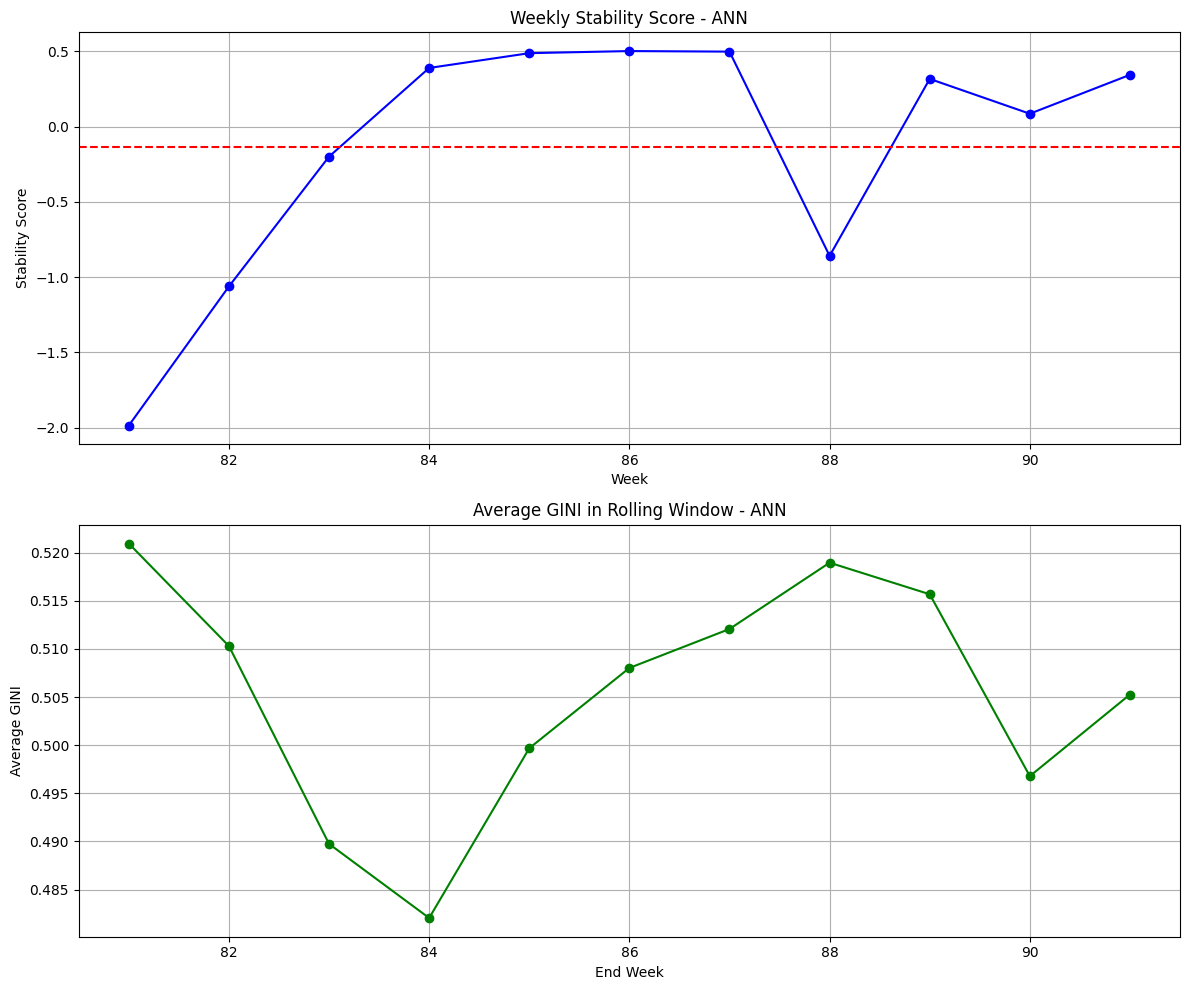

In [38]:
plot_weekly_stability(stability_results)

In [49]:
def plot_weekly_stability_auc(stability_df):
    """
    Plot the weekly stability metrics (stability score and GINI) on the same graph.

    Parameters:
    -----------
    stability_df : pd.DataFrame
        DataFrame with weekly stability metrics, as returned by calculate_weekly_rolling_stability
    """
    # Clear any existing plots to prevent duplicates
    plt.clf()
    plt.close('all')

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create twin y-axis for GINI
    ax2 = ax.twinx()

    # Plot stability score on primary axis
    line1, = ax.plot(stability_df['end_week'], stability_df['stability_score'], 'b-', marker='o', label='Stability Score')
    ax.set_ylabel('Stability Score', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot average GINI on secondary axis
    line2, = ax2.plot(stability_df['end_week'], (stability_df['avg_gini']+1)/2, 'g-', marker='o', label='AUC')
    ax2.set_ylabel('AUC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add mean stability line
    mean_stability = stability_df['stability_score'].mean()
    line3 = ax.axhline(y=mean_stability, color='r', linestyle='--', label=f'Mean Stability: {mean_stability:.2f}')

    # Add mean GINI line
    mean_auc = ((stability_df['avg_gini']+1)/2).mean()
    line4 = ax2.axhline(y=mean_auc, color='orange', linestyle='--', label=f'Mean AUC: {mean_auc:.2f}')

    # Set title and labels
    ax.set_title('Weekly Stability Score and AUC - ANN')
    ax.set_xlabel('Week')
    ax.grid(True)

    # Combine legends from both axes and place it outside the plot area
    lines = [line1, line2, line3, line4]
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=4)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend at the bottom

    return

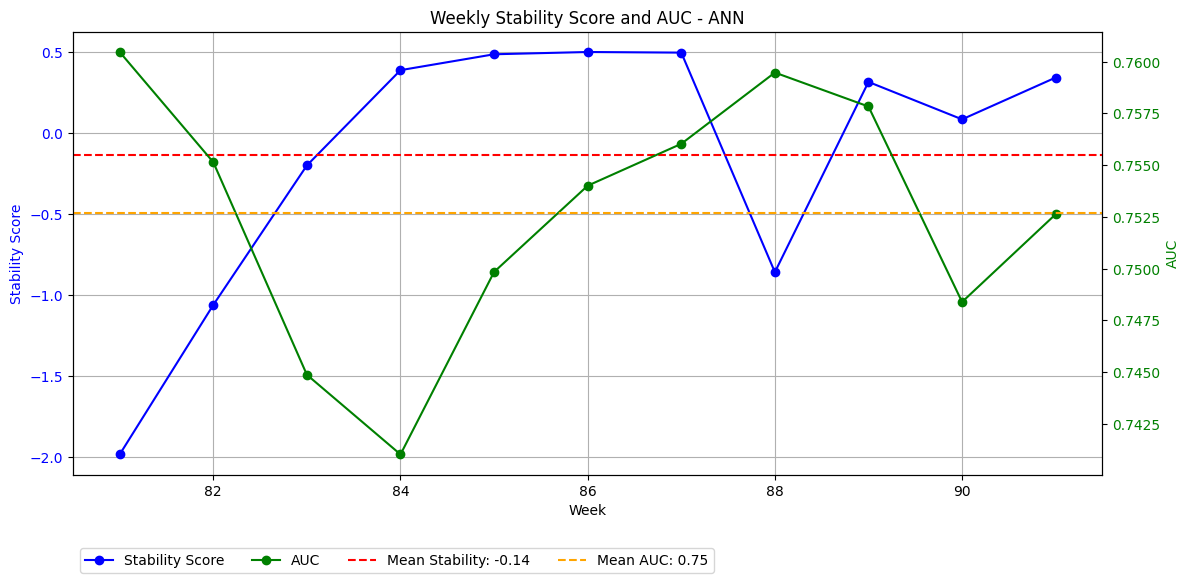

In [50]:
plot_weekly_stability_auc(stability_results)

In [41]:
# Combine all three datasets into one
full_combined_df = pd.concat(
    [base_train, base_valid, base_test],
    axis=0,          # Concatenate vertically (stack rows)
    ignore_index=False  # Keep original indices
)

In [42]:
print("AUC:", roc_auc_score(full_combined_df["target"], full_combined_df["score"]))
print("Stability:", stability_score)

AUC: 0.7459487042780828
Stability: 0.46328692800639903


In [43]:
gini_0_65, stability_0_65 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] >= 0) & (full_combined_df['WEEK_NUM'] <= 65)])
print("AUC week 0-65:",  np.mean([(g + 1) / 2 for g in gini_0_65]))
print("Stability week 0-65:", stability_0_65)

AUC week 0-65: 0.738320188863213
Stability week 0-65: 0.46074268765431603


In [44]:
gini_0_60, stability_0_60 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] >= 0) & (full_combined_df['WEEK_NUM'] <= 60)])
print("AUC week 0-60:",  np.mean([(g + 1) / 2 for g in gini_0_60]))
print("Stability week 0-60:", stability_0_60)

AUC week 0-60: 0.7387945640856985
Stability week 0-60: 0.46259685164787573


In [45]:
gini_60_65, stability_60_65 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 60) & (full_combined_df['WEEK_NUM'] <= 65)])
print("AUC week 60-65:", np.mean([(g + 1) / 2 for g in gini_60_65]))
print("Stability week 60-65:", stability_60_65)

AUC week 60-65: 0.7325328111488905
Stability week 60-65: 0.33554331664164716


In [46]:
gini_65_70, stability_65_70 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 65) & (full_combined_df['WEEK_NUM'] <= 70)])
print("AUC week 65-70:", np.mean([(g + 1) / 2 for g in gini_65_70]))
print("Stability week 65-70:", stability_65_70)

AUC week 65-70: 0.7203838791026344
Stability week 65-70: 0.40703321980727425


In [47]:
gini_70_91, stability_70_91 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 70) & (full_combined_df['WEEK_NUM'] <= 91)])
print("AUC week 70-91", np.mean([(g + 1) / 2 for g in gini_70_91]))
print("Stability week 70-91", stability_70_91)

AUC week 70-91 0.7545561163312045
Stability week 70-91 0.4396052928325109


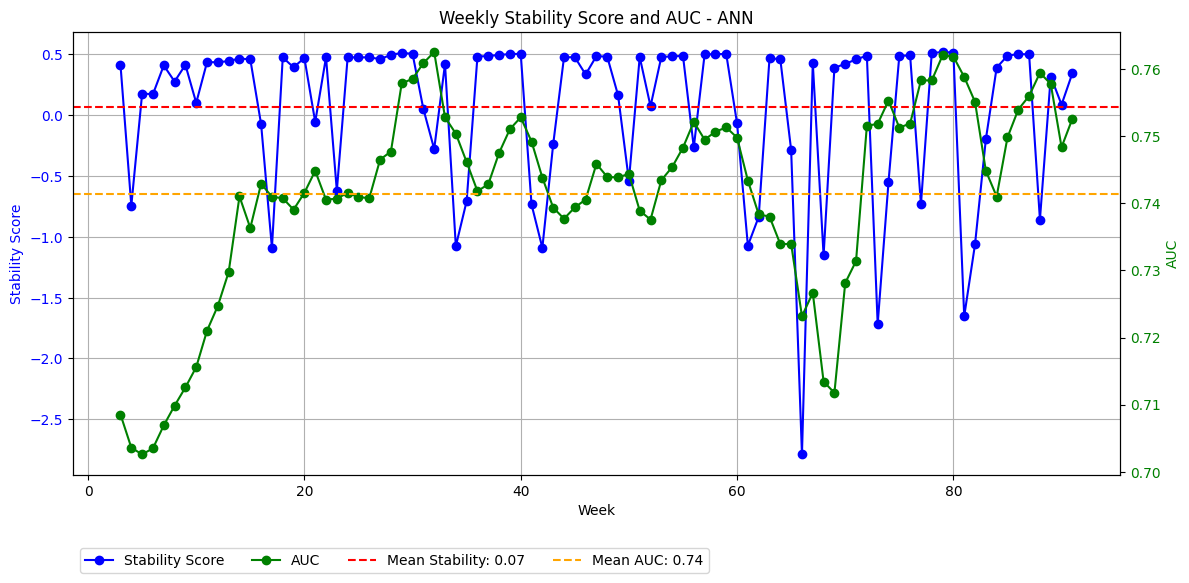

In [51]:
stability_results_all = calculate_weekly_rolling_stability(full_combined_df, window_weeks=4)
plot_weekly_stability_auc(stability_results_all)